In [1]:
import numpy as np
import csv
import os
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as colors
COLORS = list(colors.CSS4_COLORS.keys())
import warnings
import scipy
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import random
import FloRodMethods as frm
import time
from tensorflow.keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Conv1DTranspose
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Flatten
import tensorflow as tf
import keras
%matplotlib inline

In [2]:
def load_region(file):  
    df = pd.read_csv(file)
    df.index = df['timestamp']
    del df['timestamp']
    return df

In [3]:
DAYS = [31,28,31,30,31,30,31,31,30,31,30,31]
#useful tool for seeing which day of the year marks the beginning of various months
DAYS_SUM = [sum(DAYS[0:k]) for k in range(12)]
DAYS_SUM

[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334]

In [4]:
df = load_region('C:/Users/DJFRO/Hubs/Clustering/county1000.csv')

In [5]:
clusters = np.load('kmeans112.npy')

In [6]:
data = np.asarray(df[DAYS_SUM[5]*24*4:DAYS_SUM[8]*24*4]).astype('float16').T
#only rows corresponding to june through august, and transposing it in the form of an array
blds, t_len = data.shape
num_days = t_len//(24*4)
data_days = data.reshape(blds,num_days,24*4)
#tensor of blds, by days, by daily measurements

## Choosing cluster 71


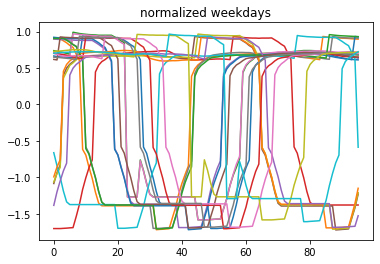

In [7]:
dataWeeks = data[128,:91*24*4].reshape(-1,7*24*4)
weekdays = np.concatenate([dataWeeks[:,:24*4],dataWeeks[:,24*4*3:]],axis=1)
x,y = frm.splitSeqs(weekdays.reshape(-1),1,24*4)
yn = (y-np.mean(y,axis=1,keepdims=True))/np.std(y,axis=1,keepdims=True)
yn_tensor = yn.reshape(yn.shape[0],yn.shape[1],1)
frm.showRandRows(yn,20)
plt.title('normalized weekdays');

In [8]:
'c2 c2 f d20 d15 d3'.split()

['c2', 'c2', 'f', 'd20', 'd15', 'd3']

In [11]:
# train a generative adversarial network on a one-dimensional function


'''     model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.FalseNegatives()]) '''
## new code ## new code ## new code ## new code ## new code ## new code
 ## new code ## new code ## new code ## new code ## new code ## new code
   ## new code ## new code ## new code ## new code ## new code ## new code


def define_discriminator(n_inputs=24*4,lr = 1e-3,in_shape=None, arch = 'c4 c4 f d48 d18 d9'):
    count = 1
    model = Sequential()
    for layer in arch.split():
        if layer=='f':
            model.add(Flatten(name='f'+str(count))) 
        elif 'c' in layer:
            kernel_size = int(layer[1:])
            model.add(Conv1D(1, kernel_size, activation='relu', name = "c"+str(count)))
        elif 'd' in layer:
            cells = int(layer[1:])
            model.add(Dense(cells, activation='relu', kernel_initializer='he_uniform', 
                            name = "d"+str(count)))
        count+=1
    model.add(Dense(1, activation='sigmoid', name = "d_final"))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
                  metrics=['accuracy'])
#     model.summary()
    return model
 
# define the standalone generator model
def define_generator(latent_dim, n_outputs=24*4, in_shape=None, arch = '16 16 24'):
    model = Sequential()
    count=1
    for cells in arch.split():
        model.add(Dense(int(cells), activation='tanh', kernel_initializer='he_uniform',
                    input_shape=in_shape, name = "fc"+str(count)))
        count+=1
    model.add(Conv1DTranspose(1, 96-latent_dim+1, name = "ct_final"))
    return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator, lr=1e-3):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))
#     model.summary()
    return model
 
# generate n real samples with class labels
def generate_real_samples(x,n):
    # generate inputs in [-0.5, 0.5]
    np.random.shuffle(x)

    X = x[:n,:,:]
    # generate class labels
    y = np.ones((n, 1))
    return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    #made a method to allow future editing
    return np.random.randn(n,latent_dim,1)
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = np.zeros((n, 1))
    return X, y
 
# evaluate the discriminator and plot real and fake curves
def summarize_performance(epoch, generator, discriminator, latent_dim,
                          n=20, M=None, saveplot=False,label=''):
    # prepare real samples
    x_real, y_real = generate_real_samples(M,n)
    
    # evaluate discriminator on real examples
    loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('EPOCH: ',epoch,'  REAL ACC: ', acc_real,'  FAKE ACC: ', acc_fake)
    print('xreal ',x_real.shape, 'x_fake' ,x_fake.shape)

    frm.dispRandRows(x_real,12, figsize=(8,4), 
                 title='real signals at '+str(epoch)+' epochs')
    plt.show()

    frm.dispRandRows(x_fake,12, figsize=(8,4),
                 title='fake signals at '+str(epoch)+' epochs')
    if saveplot:
        plt.savefig('records/'+label)
    plt.show()
    return

# evaluate the discriminator and plot real and fake curves
def save_progress(epoch, generator, discriminator, latent_dim,
                  x_real, y_real,x_fake, y_fake, progress = [], label=''):
    # evaluate discriminator on real examples
    loss_real, acc_real = discriminator.evaluate(x_real, y_real, verbose=0)
    # evaluate discriminator on fake examples
    loss_fake, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    progress.append([epoch,loss_real, acc_real,loss_fake, acc_fake])
    df = pd.DataFrame(progress,columns=['epoch','r_loss','r_acc','f_loss','f_acc'])
    df.to_csv('records/'+label+'.csv')
    return

# train the generator and discriminator

def train(g_model, d_model, gan_model, latent_dim, n_epochs=1000,
          n_batch=128, n_eval=100, M=None, label='', n_save=50):
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    progress=[]
    # manually enumerate epochs
    t0 = time.time()
    for i in range(n_epochs):
        # prepare real samples
        x_real, y_real = generate_real_samples(M,n_batch)
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_batch)
        x_all , y_all = np.concatenate([x_real, x_fake]), np.concatenate([y_real, y_fake])
        # double the data and epochs for discriminator as
        # its performance is the lower bound for our GAN's success
        # update discriminator
        d_model.fit(x_all, y_all, verbose=0, epochs =2)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = np.ones((n_batch, 1))
        # update the generator via the discriminator's error
        gan_model.fit(x_gan, y_gan, verbose=0)
        # evaluate the model every n_eval epochs
        if i % n_eval == 0 or i+1==n_epochs:
            if i+1!=n_epochs:
                summarize_performance(i, g_model, d_model, latent_dim,M=M)
            else:
                summarize_performance(i, g_model, d_model, latent_dim,M=M,
                                      saveplot=True, label=label)
            dt = time.time()-t0
            print((label+'    ')*2+'\n',"We're doing about 200 epochs in ", 
                  np.round(dt*200/((i+1)*60),2), ' min')
        if (i+1) % n_save==0 or i+1==n_epochs:
            save_progress(i, generator, discriminator, latent_dim,
                  x_real, y_real,x_fake, y_fake, progress = progress, label=label) 
    timestr = frm.tstr()[4:-8]
    g_model.save('models/gen_'+label+timestr)  
    d_model.save('models/disc_'+label+timestr) 
    gan_model.save('models/GAN_'+label+timestr) 
    return


EPOCH:  0   REAL ACC:  0.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


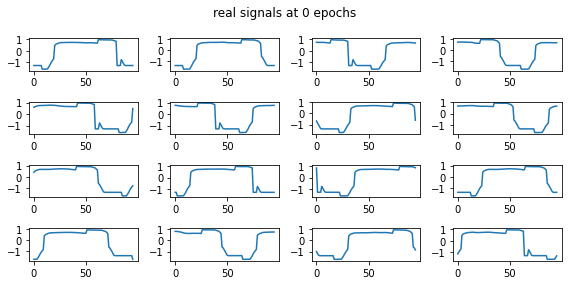

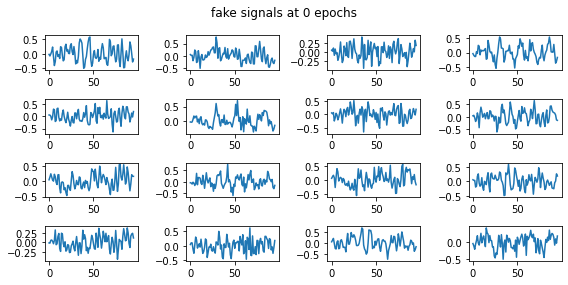

DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  13.57  min
EPOCH:  200   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


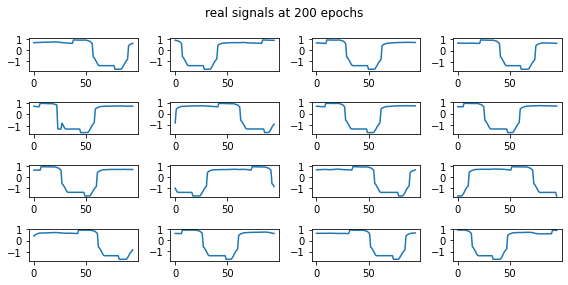

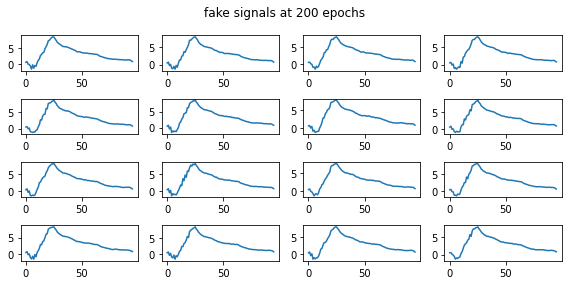

DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  0.56  min
EPOCH:  400   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


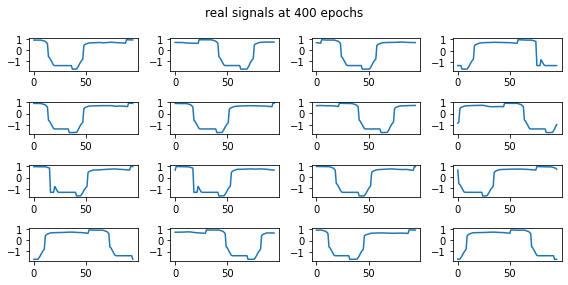

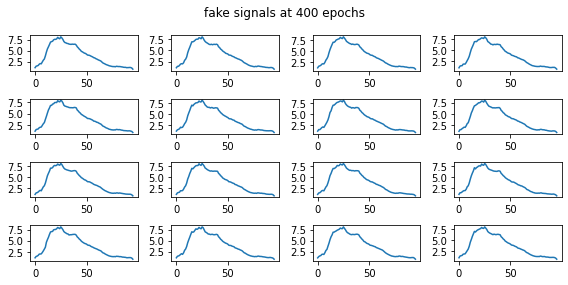

DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  0.53  min
EPOCH:  600   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


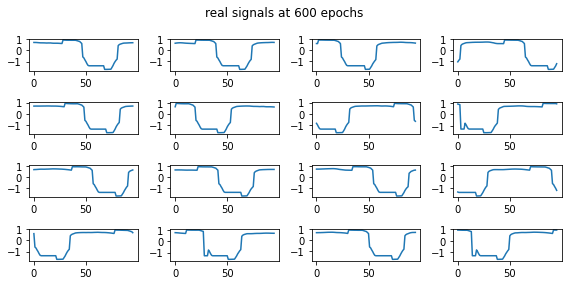

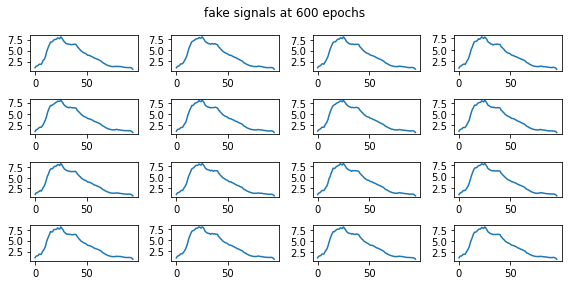

DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  0.52  min
EPOCH:  800   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


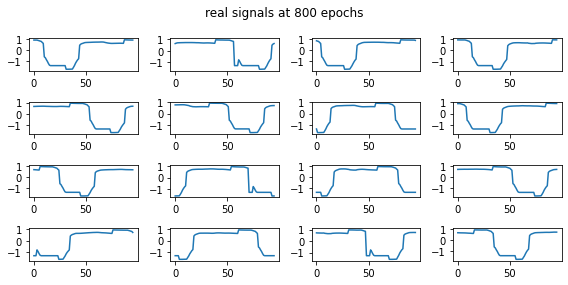

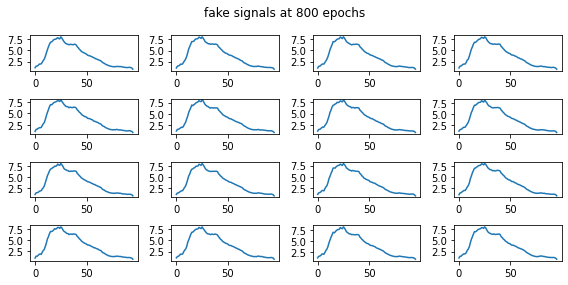

DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  0.51  min
EPOCH:  999   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


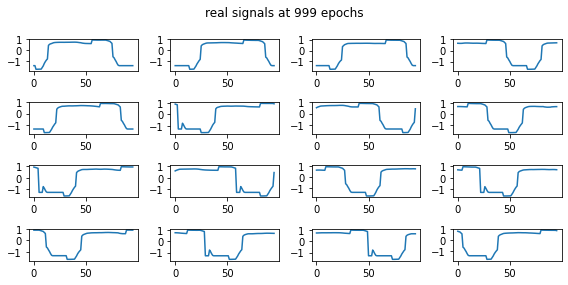

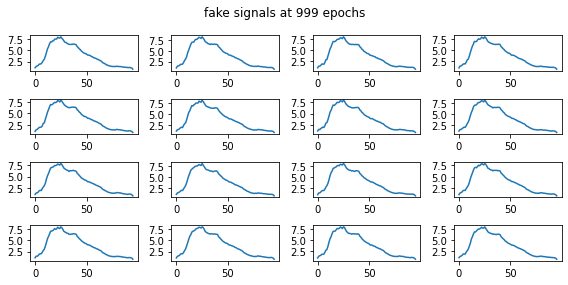

DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 DDConv16 16 24_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  0.5  min


INFO:tensorflow:Assets written to: models/gen_DDConv16 16 24_c4 c4 f d48 d18 d9Aug__5_02_21\assets


INFO:tensorflow:Assets written to: models/gen_DDConv16 16 24_c4 c4 f d48 d18 d9Aug__5_02_21\assets


INFO:tensorflow:Assets written to: models/disc_DDConv16 16 24_c4 c4 f d48 d18 d9Aug__5_02_21\assets


INFO:tensorflow:Assets written to: models/disc_DDConv16 16 24_c4 c4 f d48 d18 d9Aug__5_02_21\assets


INFO:tensorflow:Assets written to: models/GAN_DDConv16 16 24_c4 c4 f d48 d18 d9Aug__5_02_21\assets


INFO:tensorflow:Assets written to: models/GAN_DDConv16 16 24_c4 c4 f d48 d18 d9Aug__5_02_21\assets


EPOCH:  0   REAL ACC:  0.44999998807907104   FAKE ACC:  0.800000011920929
xreal  (20, 96, 1) x_fake (20, 96, 1)


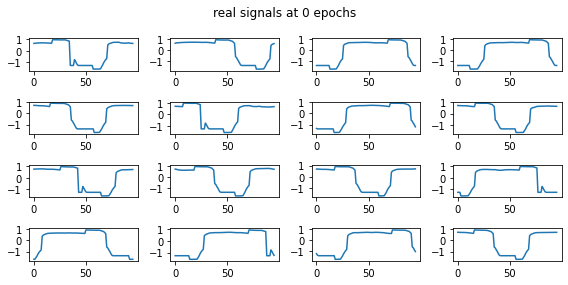

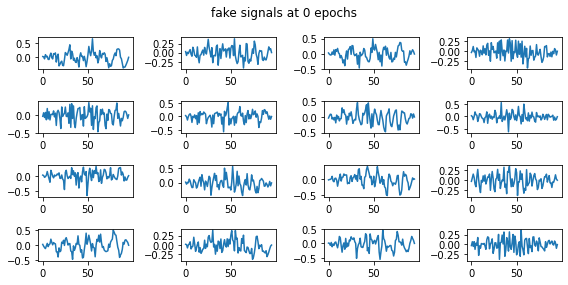

DDConv8 8 16_c4 c4 f d48 d18 d9 DDConv8 8 16_c4 c4 f d48 d18 d9 DDConv8 8 16_c4 c4 f d48 d18 d9 DDConv8 8 16_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  13.96  min
EPOCH:  200   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


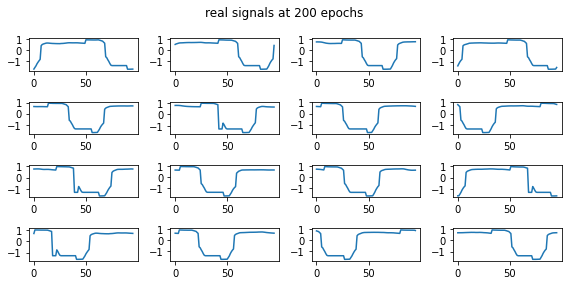

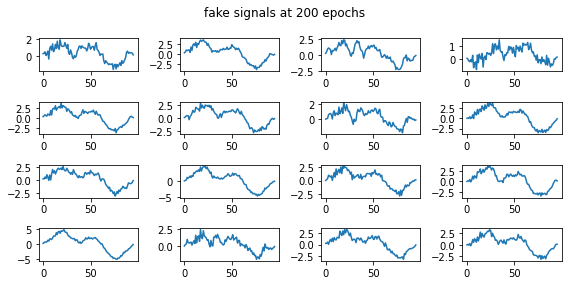

DDConv8 8 16_c4 c4 f d48 d18 d9 DDConv8 8 16_c4 c4 f d48 d18 d9 DDConv8 8 16_c4 c4 f d48 d18 d9 DDConv8 8 16_c4 c4 f d48 d18 d9 
 We're doing about 200 epochs in  0.57  min
EPOCH:  400   REAL ACC:  1.0   FAKE ACC:  1.0
xreal  (20, 96, 1) x_fake (20, 96, 1)


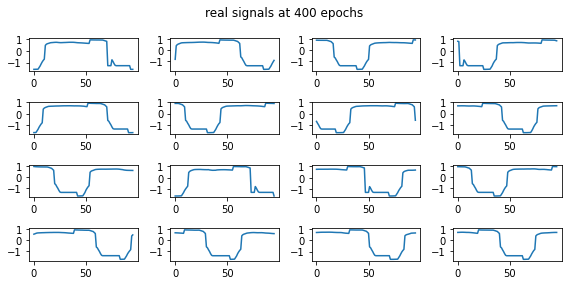

In [ ]:

# size of the latent space
latent_dim = 16
batch = 128
d_archs = ['c4 c4 f d48 d18 d9','c4 c4 c4 f d48 d18 d9','c4 c4 f d36 d12 d6','c4 c4 c4 f d36 d12 d6',
          'c4 c4 f d24 d24 d24 d12','c4 c4 c4 f d24 d24 d24 d12','c4 c4 f d3 d4 d4','c4 c4 f d3 d4 d4']
g_archs = ['16 16 24','8 8 16','16 16 16','16 16 16 24','5 7 7 4','12 16 24 32']
for d_arch in d_archs:
    for g_arch in g_archs:
        
        # create the discriminator
        discriminator = define_discriminator(n_inputs=24*4,in_shape=(batch,24*4,1),arch = d_arch)
        # create the generator
        generator = define_generator(latent_dim, n_outputs =24*4,in_shape=(batch,latent_dim,1), arch= g_arch)
        # create the gan
        gan_model = define_gan(generator, discriminator)
        # train model
        train(generator, discriminator, gan_model, latent_dim,M=yn_tensor, 
              n_epochs=1000,n_eval=200, label ='DDConv'+g_arch+'_'+d_arch)